In [1]:
from sklearn.datasets import  load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 확인

In [2]:
iris = load_iris()   # numpy 반환

In [3]:
iris_df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
iris_df['label'] = iris.target

In [4]:
print(iris_df.info())
print(iris_df.describe())
print(iris_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB
None
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000        

# 결측치 확인

In [5]:
nan_dict = {"CNT":iris_df.isna().sum(),
            "RATE": iris_df.isna().sum()/iris_df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))

Empty DataFrame
Columns: [CNT, RATE]
Index: []


In [6]:
zero_dict = {"CNT":iris_df.isin([0]).sum(),
            "RATE": iris_df.isin([0]).sum()/iris_df.shape[0] *100
}
zero_df = pd.DataFrame(zero_dict)
print(zero_df[zero_df["RATE"]>0].sort_values("CNT", ascending=False))

       CNT       RATE
label   50  33.333333


# 분류 예측

In [7]:
X_train, X_test, y_train, y_test = train_test_split(iris_df[iris_df.columns.difference(["label"])],
                                                    iris_df["label"],
                                                   test_size = 0.2, random_state = 11)

In [8]:
dt = DecisionTreeClassifier(random_state=156)

In [9]:
# max_depth: 트리의 최대 깊이, 깊어질수록 과적합 가능성 증가 
# min_samples_split: 노드를 분할하기위한 최고한의 샘플 데이터 수, 작게 설정할수록 과적합 가능성 증가
parameters = {'max_depth': [1, 3, 5], 'min_samples_split':[2, 3]}
gcv = GridSearchCV(dt, param_grid=parameters, cv=5, refit=True)
gcv.fit(X_train, y_train)

print(gcv.best_score_)
print(gcv.best_estimator_)
print(gcv.best_params_)

0.9666666666666668
DecisionTreeClassifier(max_depth=3, random_state=156)
{'max_depth': 3, 'min_samples_split': 2}


In [10]:
scores_df = pd.DataFrame(gcv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score','split1_test_score','split2_test_score',
           'split3_test_score', 'split4_test_score']].sort_values("rank_test_score")

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
2,"{'max_depth': 3, 'min_samples_split': 2}",0.966667,1,0.916667,0.958333,1.000000,0.958333,1.000000
3,"{'max_depth': 3, 'min_samples_split': 3}",0.966667,1,0.916667,0.958333,1.000000,0.958333,1.000000
4,"{'max_depth': 5, 'min_samples_split': 2}",0.958333,3,0.916667,0.958333,1.000000,0.916667,1.000000
5,"{'max_depth': 5, 'min_samples_split': 3}",0.958333,3,0.916667,0.958333,1.000000,0.916667,1.000000
0,"{'max_depth': 1, 'min_samples_split': 2}",0.675000,5,0.708333,0.666667,0.666667,0.666667,0.666667
1,"{'max_depth': 1, 'min_samples_split': 3}",0.675000,5,0.708333,0.666667,0.666667,0.666667,0.666667


In [11]:
pred = gcv.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))

Accuracy: 0.9333


# 시각화

In [12]:
from sklearn.tree import export_graphviz
import graphviz

In [13]:
export_graphviz(gcv.best_estimator_, out_file="tree.dot", feature_names=iris_df.columns.difference(["label"]),
                class_names="label", impurity=True, filled=True)

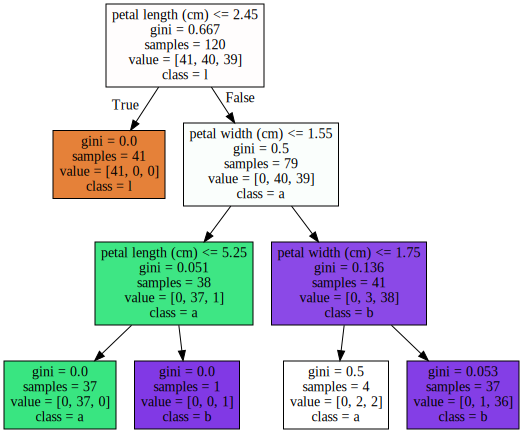

In [14]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'label'],
      dtype='object')


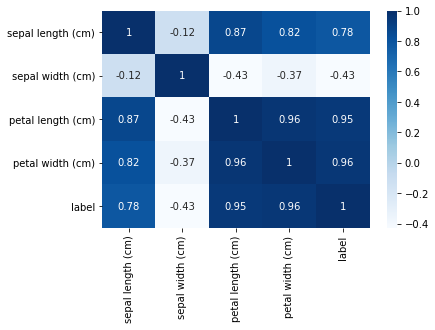

In [16]:
# 피쳐 관계 
print(iris_df.columns)
sns.heatmap(iris_df.corr(), annot=True, cmap='Blues')
plt.show()

DecisionTreeClassifier(max_depth=3, random_state=156)
Accuracy : 0.933333

Feature importances:
[0.558 0.442 0.    0.   ]
petal length (cm) : 0.558
petal width (cm) : 0.442
sepal length (cm) : 0.000
sepal width (cm) : 0.000


<AxesSubplot:>

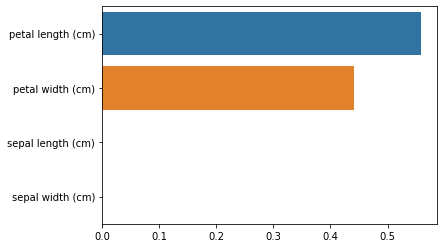

In [17]:
pred = gcv.best_estimator_.predict(X_test)
df_score = accuracy_score(pred, y_test)
print(gcv.best_estimator_)
print("Accuracy : {:.6f}".format(df_score))

print('\nFeature importances:\n{0}'.format(np.round(gcv.best_estimator_.feature_importances_, 3)))

# feature 별 importance 매핑
for name, value in zip(iris_df.columns.difference(["label"]), gcv.best_estimator_.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화하기
sns.barplot(x=gcv.best_estimator_.feature_importances_, y=iris_df.columns.difference(["label"]))